In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.font_manager
plt.rcParams["font.family"] = "Times New Roman"

# Analysis and Evaluation of Adversarial Training and Attacks on the Different Model Classes

## Tools and Setups

In [2]:
# -------------------------- RECALL THE PRETRAIN SETUPS -------------------------- #

# GLOBAL SETUPS
eps_training = [0.075]  # [0.02, 0.05, 0.1]
pgd_steps_training = [10]  # [5, 10, 20]
training_epochs = [1, 5, 10, 20, 50]
data_set_names = ['mnist', 'fashion_mnist']

# SETUPS FOR ALL SINGLE BASE ARCHITECTURES
architecture_layouts = {1: [100, 10],
                        2: [200, 200, 10],
                        3: [300, 300, 300, 10],
                        4: [400, 400, 400, 400, 10]
                        }
architectures = [1, 2, 3, 4]

# INDIVIDUAL SETUPS
# Simple fully connected --> no additional setups
# RSE and BNN
eot = ['False', 'True']
eot_steps_training = [10]  # [10, 20, 50]
# Ensemble
mode = ['individual', 'collective']
collective_architectures = [[[100, 10], [200, 10], [50, 100, 10]],
                            [[300, 200, 10], [500, 200, 10], [500, 500, 200, 10]],
                            [[100, 10], [200, 10], [200, 100, 10], [300, 200, 100, 10], [500, 200, 10]],
                            [[500, 300, 200, 10], [500, 500, 200, 10], [500, 400, 300, 200, 100, 10],
                             [512, 1024, 512, 256, 10], [512, 512, 256, 256, 10]]]


In [3]:
# ITERATORS FOR THE DIFFERENT MODEL CLASSES AND TRAINING TYPES
fc_iterator = list(it.product(architectures, data_set_names))
adv_fc_iterator = list(it.product(architectures, data_set_names, eps_training, pgd_steps_training))

ensemble_iterator = list(it.product(architectures, data_set_names))
adv_ensemble_iterator = list(it.product(architectures, data_set_names, eps_training, pgd_steps_training, mode))

rse_iterator = list(it.product(architectures, data_set_names))
adv_rse_iterator = list(it.product(architectures, data_set_names, eps_training, pgd_steps_training, eot))

bnn_iterator = list(it.product(architectures, data_set_names))
adv_bnn_iterator = list(it.product(architectures, data_set_names, eps_training, pgd_steps_training, eot))

In [4]:
# LOAD THE DATA

header = np.array(['net_type', 'net_num', 'data_set', 'n_epochs', 'training', 'eps_train', 'pgd_steps_train', 
                   'eot_train', 'eot_steps_train', 'eps_test', 'pgd_steps_test', 'eot_test', 'eot_steps_test',
                   'test_acc', 'adv_acc'])

def get_fc_path(specs):
    if len(specs) == 2:
        folder_prompt = f'fc_nonadv_{specs[1]}_arch{specs[0]}'
        return f'pre_trained_models/fc_nets/{folder_prompt}/{folder_prompt}.csv'
    elif len(specs) == 4:
        folder_prompt = f'fc_adv_{specs[1]}_arch{specs[0]}_eps{specs[2]}_steps{specs[3]}'
        return f'pre_trained_models/fc_nets/{folder_prompt}/{folder_prompt}.csv'
    else:
        raise NotImplementedError
        
        
def get_fc_ensemble_path(specs):
    if len(specs) == 2:
        folder_prompt = f'ensemble_nonadv_{specs[1]}_archcol{specs[0]}'
        return f'pre_trained_models/fc_ensemble_nets/{folder_prompt}/{folder_prompt}.csv'
    elif len(specs) == 5:
        folder_prompt = f'ensemble_adv_{specs[1]}_archcol{specs[0]}_eps{specs[2]}_steps{specs[3]}_mode{specs[4]}'
        return f'pre_trained_models/fc_ensemble_nets/{folder_prompt}/{folder_prompt}.csv'
    else:
        raise NotImplementedError
        

def get_rse_path(specs):
    if len(specs) == 2:
        folder_prompt = f'rse_nonadv_{specs[1]}_arch{specs[0]}'
        return f'pre_trained_models/rse_nets/{folder_prompt}/{folder_prompt}.csv'
    elif len(specs) == 5:
        folder_prompt = f'rse_adv_{specs[1]}_arch{specs[0]}_eps{specs[2]}_steps{specs[3]}_eot{specs[4]}'
        return f'pre_trained_models/rse_nets/{folder_prompt}/{folder_prompt}.csv'
    else:
        raise NotImplementedError
        
        
def get_bnn_path(specs):
    if len(specs) == 2:
        folder_prompt = f'bnn_nonadv_{specs[1]}_arch{specs[0]}'
        return f'pre_trained_models/bnn_nets/{folder_prompt}/{folder_prompt}.csv'
    elif len(specs) == 5:
        folder_prompt = f'bnn_adv_{specs[1]}_arch{specs[0]}_eps{specs[2]}_steps{specs[3]}_eot{specs[4]}'
        return f'pre_trained_models/bnn_nets/{folder_prompt}/{folder_prompt}.csv'
    else:
        raise NotImplementedError
       
    
model_paths = {
    'fc_nets': get_fc_path,
    'fc_ensemble_nets': get_fc_ensemble_path,
    'rse_nets': get_rse_path,
    'bnn_nets': get_bnn_path
}

models_to_load = {
    'fc_nets': (fc_iterator, adv_fc_iterator),
    'fc_ensemble_nets': (ensemble_iterator, adv_ensemble_iterator),
    'rse_nets': (rse_iterator, adv_rse_iterator),
    'bnn_nets': (bnn_iterator, adv_bnn_iterator)
}

models_to_load = {
    'fc_nets': [fc_iterator, adv_fc_iterator],
    'fc_ensemble_nets': [ensemble_iterator, adv_ensemble_iterator],
    'rse_nets': [rse_iterator, adv_rse_iterator],
    'bnn_nets': [bnn_iterator, adv_bnn_iterator]
}

all_dataframes = []
for model in models_to_load:
    print(model)
    for iterator in models_to_load[model]:
        for spec in iterator:
            path = model_paths[model](spec)
            all_dataframes.append(pd.read_csv(path, delimiter=',', index_col=0))
            
complete_data = pd.concat(all_dataframes, ignore_index=True).to_numpy()

fc_nets
fc_ensemble_nets
rse_nets
bnn_nets


In [5]:
def query(in_data, query_command: dict, header: np.ndarray = None):
    '''
    A function that allows us to use numpy arrays almost in the same fashion as pandas dataframes while keeping its
    simple indexing and linear algebra compatibility.
    '''
    data = in_data.copy()
    if header is None:
        header = np.array(['net_type', 'net_num', 'data_set', 'n_epochs', 'training', 'eps_train', 'pgd_steps_train', 
                           'eot_train', 'eot_steps_train', 'eps_test', 'pgd_steps_test', 'eot_test', 'eot_steps_test',
                           'test_acc', 'adv_acc'])
    assert data.shape[1] == len(header), 'The header has to describe the data columns'
    for column_name in query_command:
        data = data[np.where(data[:, np.argwhere(header == column_name).item()] == query_command[column_name])]
    return data


def _calculate_number_of_parameters(in_size, layout, bias=True):
    num_params = in_size * layout[0]
    for i, num_neurons in enumerate(layout, 1):
        num_params += num_neurons * layout[i-1]
        num_params += num_neurons if bias else 0
    return num_params


def calculate_number_of_parameters(in_size, layout, net_type, bias=True):
    num_params = 0
    if net_type == 'fc_ensemble':
        for sub_layout in layout:
            num_params += _calculate_number_of_parameters(in_size, sub_layout, bias)
    else:
        num_params = _calculate_number_of_parameters(in_size, layout, bias)
        num_params *= 2 if net_type == 'bnn' else 1
    return num_params


def calculate_number_of_passes_for_training(n_epochs, n_data_points):
    number_of_passes = n_epochs * n_data_points
    return number_of_passes


def calculate_number_of_passes_for_pgd(pgd_steps, special_attack=False, special_attack_factor=10):
    number_of_passes_for_pgd = pgd_steps
    if special_attack:
        number_of_passes_for_pgd *= special_attack_factor
    return number_of_passes_for_pgd

## Exploratory Analysis

In this section we explore the data we obtained from out large scale analysis. Our goal is to understand our data, detect some anomalies, and answer the initial research question posed, namely, do the (randomized) ensemble models pose better solutions in safety critical applications even when normalized for factors such as model complexity, trianing difficulty, and pure accuracy loss?

### Accuracy over Epochs

We plot for each model on both datasets their performance over training. This will give us a feel for how the models' training dynamics look like and about the overall performance of each model.

In [6]:
# Attack and training params
eps_test = 0.08
pgd_steps_test = 50
eot_train = False

# Plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['x', 'o', 'v', 's']
eot_steps_test = [0, 50]

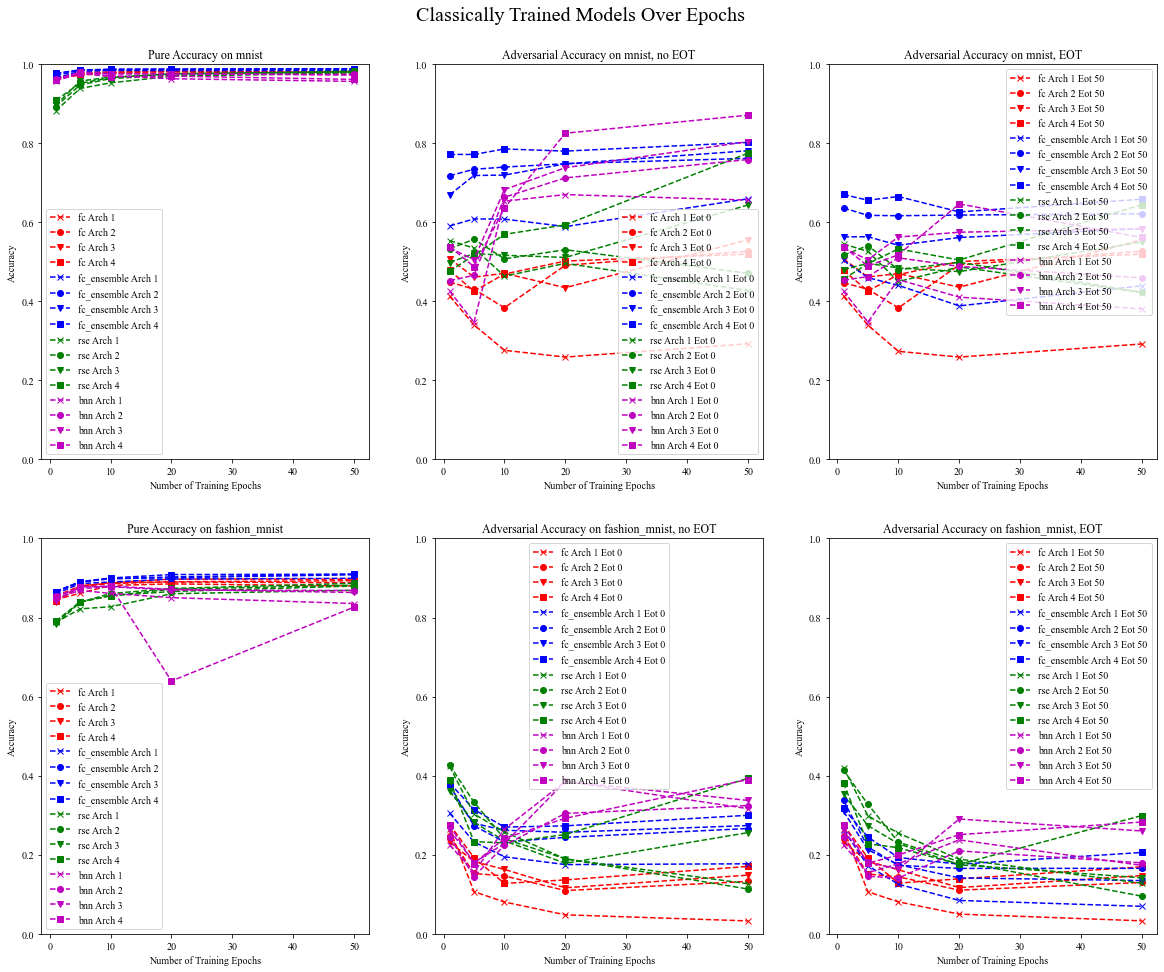

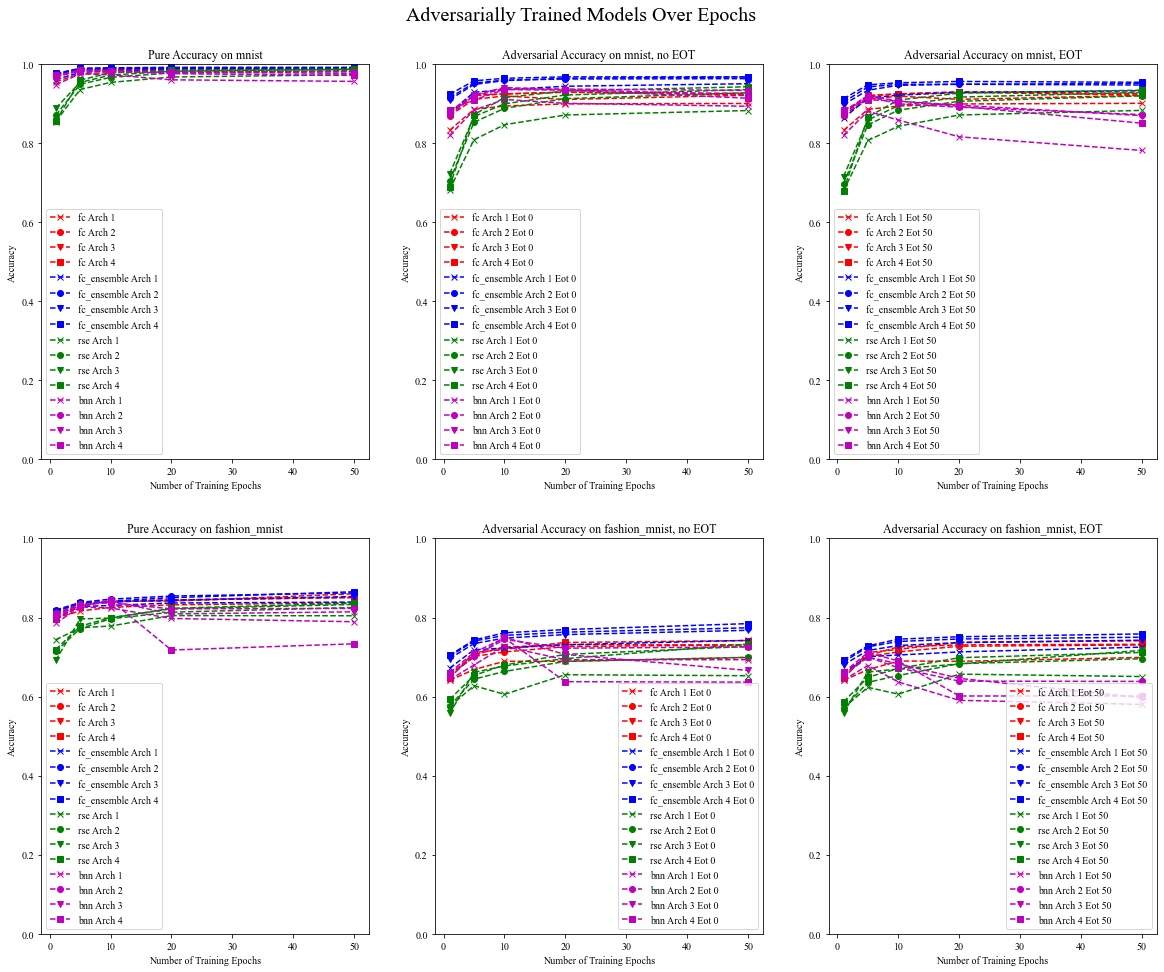

In [7]:
query_dict = {'training': 'non_adv', 'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'eot_train': False}
queried_data = query(complete_data, query_dict)

fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(20, 16))

for l, data_set in enumerate(data_set_names):
    for i, net_type in enumerate(net_types):
        for j, net_num in enumerate(architectures):
            for k, steps in enumerate(eot_steps_test):
                data_to_plot = query(queried_data.copy(), {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps})
                ax[l, k+1].plot(data_to_plot[:, 3], data_to_plot[:, -1], f'{colors[i]}--{symbols[j]}',label=f'{net_type} Arch {net_num} Eot {steps}')
                ax[l, k+1].legend()
                ax[l, k+1].set_ylim([0, 1])
            ax[l, 0].plot(data_to_plot[:, 3], data_to_plot[:, -2], f'{colors[i]}--{symbols[j]}',label=f'{net_type} Arch {net_num}')
            ax[l, 0].legend()
            ax[l, 0].set_ylim([0, 1])
    ax[l, 0].set_title(f'Pure Accuracy on {data_set}')
    ax[l, 1].set_title(f'Adversarial Accuracy on {data_set}, no EOT')
    ax[l, 2].set_title(f'Adversarial Accuracy on {data_set}, EOT')
    ax[l, 0].set_xlabel('Number of Training Epochs')
    ax[l, 0].set_ylabel('Accuracy')
    ax[l, 1].set_xlabel('Number of Training Epochs')
    ax[l, 1].set_ylabel('Accuracy')
    ax[l, 2].set_xlabel('Number of Training Epochs')
    ax[l, 2].set_ylabel('Accuracy')
fig.suptitle('Classically Trained Models Over Epochs', fontsize=20, y=0.93)
plt.show()


query_dict = {'training': 'adv', 'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test}
queried_data = query(complete_data, query_dict)

fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(20, 16))

for l, data_set in enumerate(data_set_names):
    for i, net_type in enumerate(net_types):
        for j, net_num in enumerate(architectures):
            for k, steps in enumerate(eot_steps_test):
                if net_type == 'fc':
                    data_to_plot = query(queried_data.copy(), {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps})
                else:
                    data_to_plot = query(queried_data.copy(), {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps, 'eot_train': eot_train})
                ax[l, k+1].plot(data_to_plot[:, 3], data_to_plot[:, -1], f'{colors[i]}--{symbols[j]}',label=f'{net_type} Arch {net_num} Eot {steps}')
                ax[l, k+1].legend()
                ax[l, k+1].set_ylim([0, 1])
            ax[l, 0].plot(data_to_plot[:, 3], data_to_plot[:, -2], f'{colors[i]}--{symbols[j]}',label=f'{net_type} Arch {net_num}')
            ax[l, 0].legend()
            ax[l, 0].set_ylim([0, 1])
    ax[l, 0].set_title(f'Pure Accuracy on {data_set}')
    ax[l, 1].set_title(f'Adversarial Accuracy on {data_set}, no EOT')
    ax[l, 2].set_title(f'Adversarial Accuracy on {data_set}, EOT')
    ax[l, 0].set_xlabel('Number of Training Epochs')
    ax[l, 0].set_ylabel('Accuracy')
    ax[l, 1].set_xlabel('Number of Training Epochs')
    ax[l, 1].set_ylabel('Accuracy')
    ax[l, 2].set_xlabel('Number of Training Epochs')
    ax[l, 2].set_ylabel('Accuracy')
fig.suptitle('Adversarially Trained Models Over Epochs', fontsize=20, y=0.93)
plt.show()

First of all, we can assure ourselves that the majority of the models indeed reach convergence at 50 epochs. Further, we can make the first few interesting observations:
- The fully connected ensemble model class is very strong
- The randomized models indeed show a certain adversarial defense even though not trained adversarially -- in case of the BNN this effect seems to especially strong
- The randomized models underperform when used in combination with adversarial training

### Let us plot the model performance over the model complexity (in terms of number of trainable parameters)
This experiment should allow us to gain insight into the fact if the increased performance of some of the models are only due to the increased model complexity. The main model in suspicion here is the ensemble of fully connected networks.

In [8]:
# Attack params
pgd_steps_test = 50
eps_test = 0.08
n_epochs = 50
eot_train = False

# plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['x', 'o', 'v', 's']
eot_steps_test = [0, 0, 50]

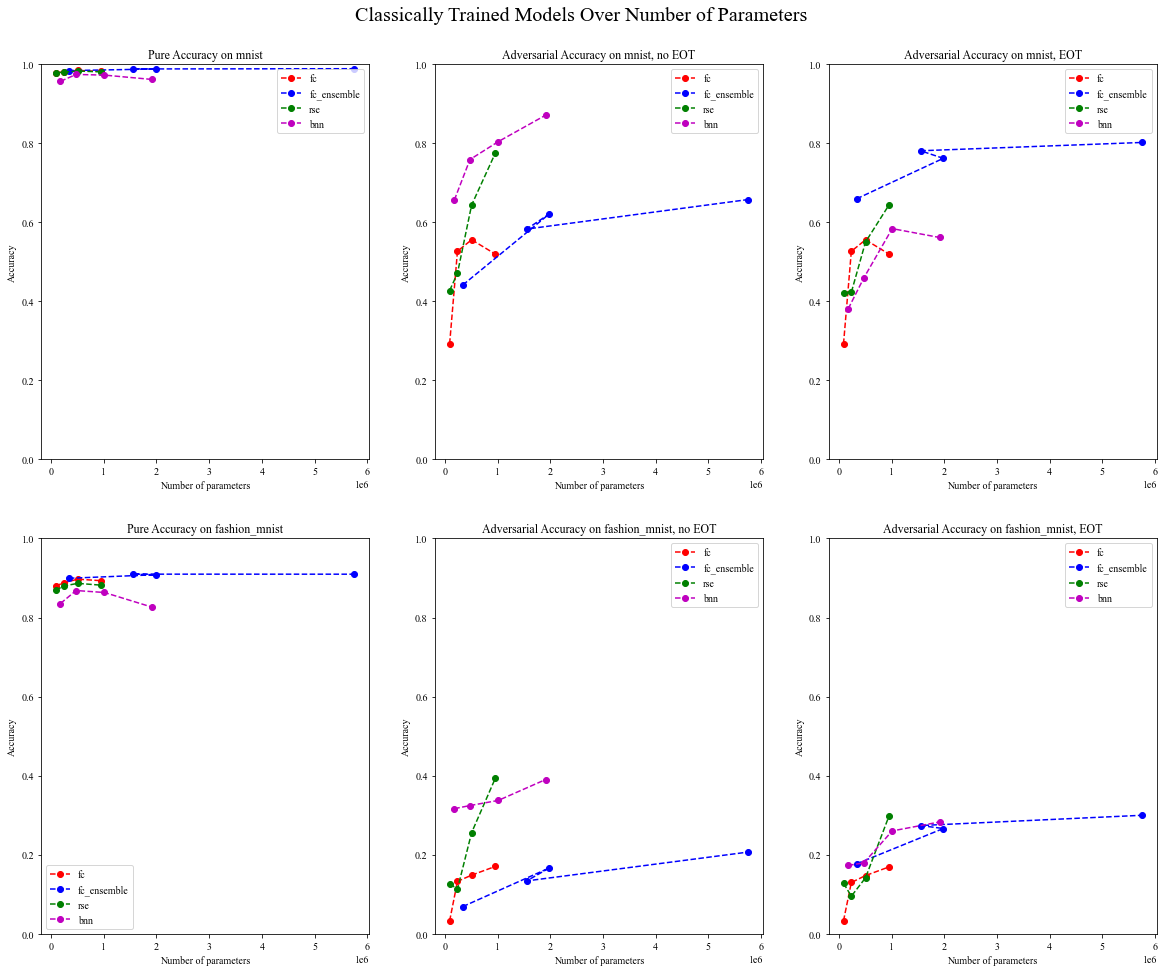

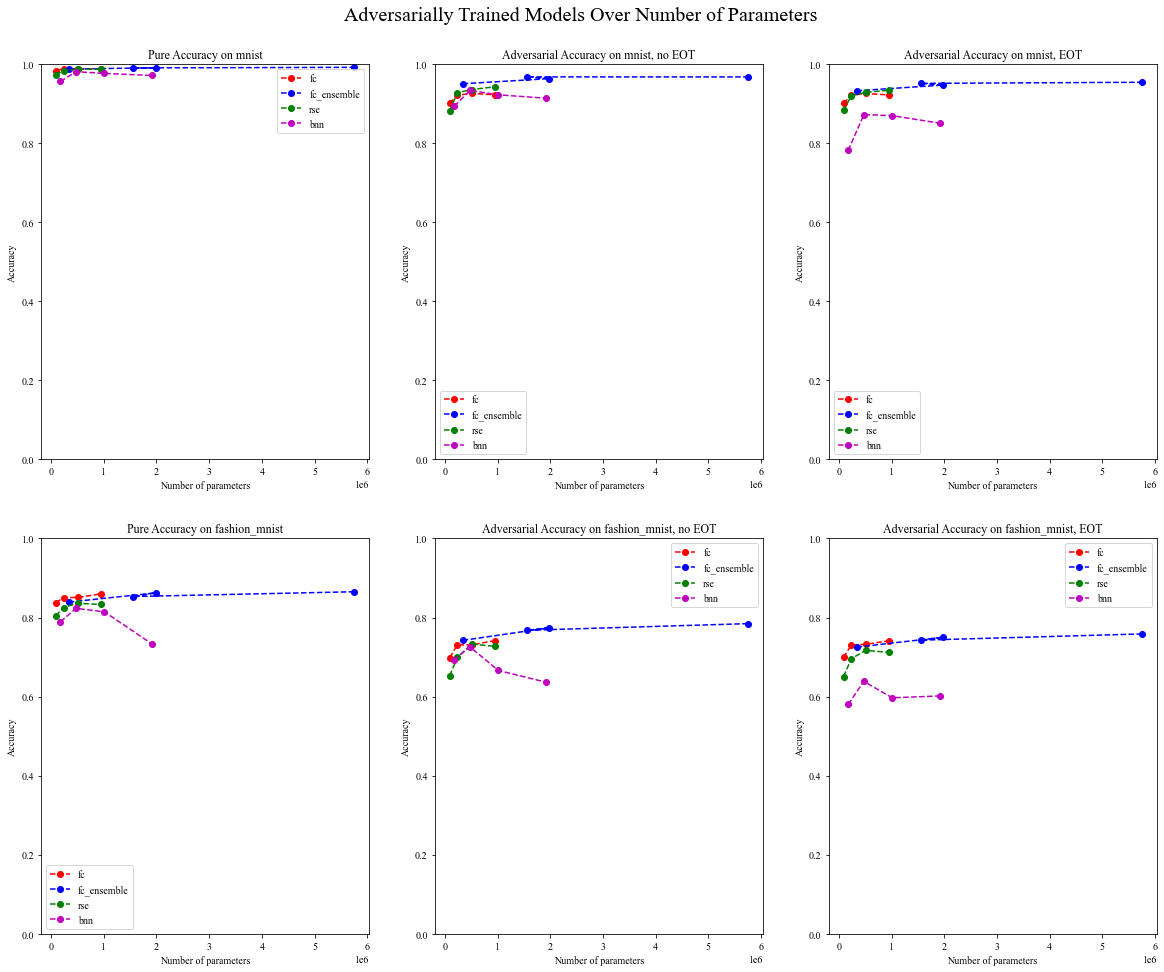

In [9]:
fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(20, 16))
query_dict = {'training': 'non_adv', 'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'n_epochs': n_epochs, 'eot_train': False}
queried_data = query(complete_data, query_dict)

for i, data_set in enumerate(data_set_names):
    for j, net_type in enumerate(net_types):
        for k, steps in enumerate(eot_steps_test):
            x_to_plot = []
            y_to_plot = []
            for l, net_num in enumerate(architectures):
                if net_type == 'fc_ensemble':
                    num_params = calculate_number_of_parameters(784, collective_architectures[l], net_type)
                    eot_test = True if k == 1 else False
                    query_to_plot = query(queried_data, {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_test': eot_test})
                else:
                    num_params = calculate_number_of_parameters(784, architecture_layouts[net_num], net_type)
                    query_to_plot = query(queried_data, {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps})
                x_to_plot.append(num_params)
                if k == 0:
                    y_to_plot.append(query_to_plot[0, -2])
                else:
                    y_to_plot.append(query_to_plot[0, -1])
            ax[i, k].plot(x_to_plot, y_to_plot, f'{colors[j]}--o', label=f'{net_type}')
            ax[i, k].legend()
            ax[i, k].set_ylim([0, 1])
            ax[i, k].set_xlabel('Number of parameters')
            ax[i, k].set_ylabel('Accuracy')
    ax[i, 0].set_title(f'Pure Accuracy on {data_set}')
    ax[i, 1].set_title(f'Adversarial Accuracy on {data_set}, no EOT')
    ax[i, 2].set_title(f'Adversarial Accuracy on {data_set}, EOT')
fig.suptitle('Classically Trained Models Over Number of Parameters', fontsize=20, y=0.93)
plt.show()


fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(20, 16))
query_dict = {'training': 'adv', 'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'n_epochs': n_epochs}
queried_data = query(complete_data, query_dict)

for i, data_set in enumerate(data_set_names):
    for j, net_type in enumerate(net_types):
        for k, steps in enumerate(eot_steps_test):
            x_to_plot = []
            y_to_plot = []
            for l, net_num in enumerate(architectures):
                if net_type == 'fc':
                    query_to_plot = query(queried_data, {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps})
                else:
                    query_to_plot = query(queried_data, {'data_set': data_set, 'net_num': net_num, 'net_type': net_type, 'eot_steps_test': steps, 'eot_train': eot_train})
                if net_type == 'fc_ensemble':
                    num_params = calculate_number_of_parameters(784, collective_architectures[l], net_type)
                else:
                    num_params = calculate_number_of_parameters(784, architecture_layouts[net_num], net_type)
                x_to_plot.append(num_params)
                if k == 0:
                    y_to_plot.append(query_to_plot[0, -2])
                else:
                    y_to_plot.append(query_to_plot[0, -1])
            ax[i, k].plot(x_to_plot, y_to_plot, f'{colors[j]}--o', label=f'{net_type}')
            ax[i, k].legend()
            ax[i, k].set_ylim([0, 1])
            ax[i, k].set_xlabel('Number of parameters')
            ax[i, k].set_ylabel('Accuracy')
    ax[i, 0].set_title(f'Pure Accuracy on {data_set}')
    ax[i, 1].set_title(f'Adversarial Accuracy on {data_set}, no EOT')
    ax[i, 2].set_title(f'Adversarial Accuracy on {data_set}, EOT')
fig.suptitle('Adversarially Trained Models Over Number of Parameters', fontsize=20, y=0.93)
plt.show()

As we can observe, our concern over the complexity of the ensemble model has held truth; it indeed performs very well, but requires significantly more parameters. Also, as already observed before, the randomized models seem to underperform when they come into combination with adversarial training; this effect is even more dramatic when normalized for the number of parameters as shown here -- BNNs have twice as many parameters as their deterministic counterparts, yet fail to even match their performance.

### Now we would like to explore how hard it is to train each of these models
We plot the performance of each model against the number of forward passes needed for training them. Here we focus on adversarial training by default, but the reader is encouraged to play around with the setups and explore the data themselves.

In [10]:
# Attack params
pgd_steps_test = 10
eps_test = 0.08
n_epochs = 50
eot_train = False

# plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['X', 'o', 'v', 's']
eot_steps_test = [0, 0, 50]
epochs = [1, 5, 10, 20, 50]
eot_train = [True, False]

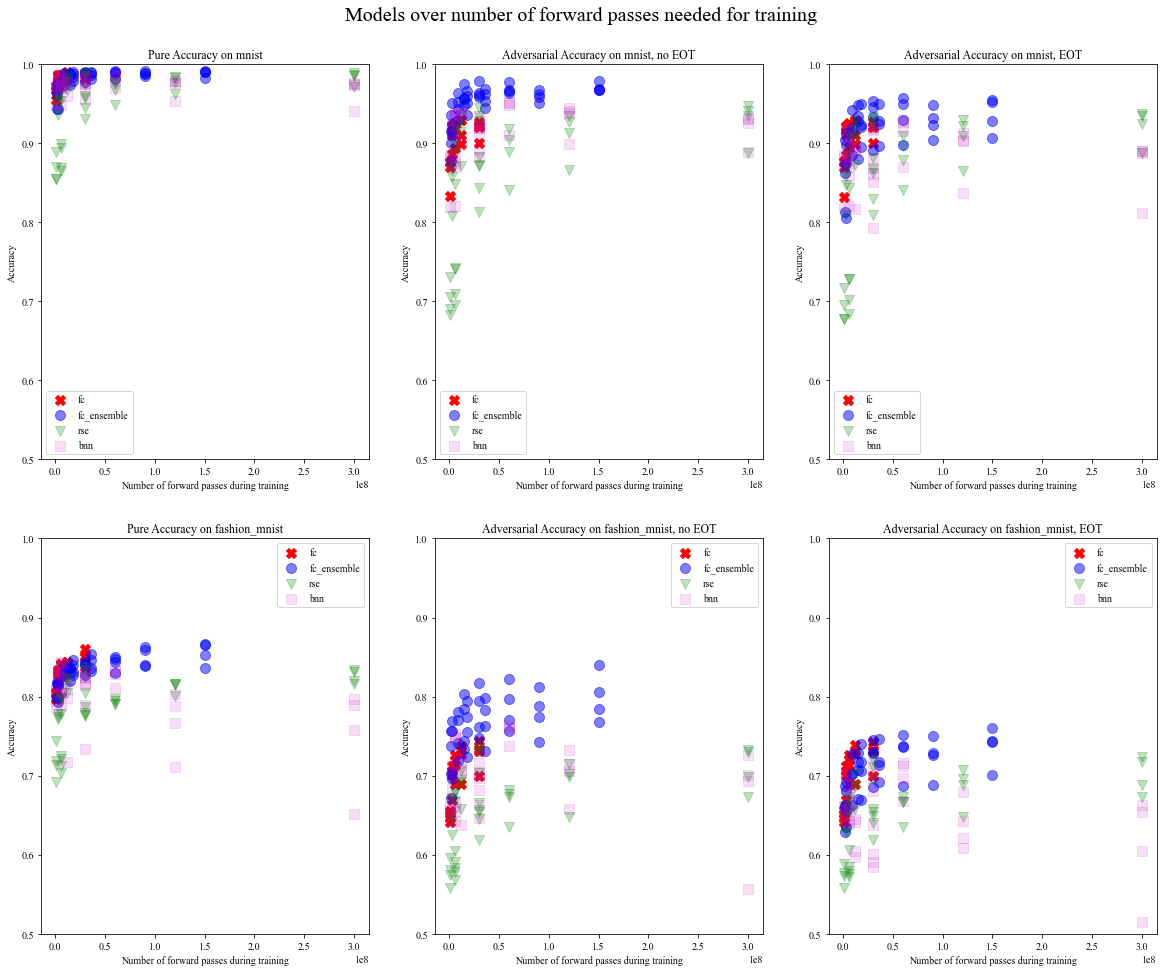

In [11]:
query_dict = {'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'training': 'adv'}  # change 'training': 'non_adv' to compare the performance of traditionally trained models
queried_data = query(complete_data, query_dict)

fig, ax = plt.subplots(2, 3, squeeze=False, figsize=(20, 16))

for i, data_set in enumerate(data_set_names):
    for j, eot_steps in enumerate(eot_steps_test):
        for k, net_type in enumerate(net_types):
            query_to_plot = query(queried_data, {'net_type': net_type, 'eot_steps_test': eot_steps, 'data_set': data_set})
            x_to_plot = []
            y_to_plot = []
            for line in query_to_plot:
                if j == 0:
                    y_to_plot.append(line[-2])
                else:
                    y_to_plot.append(line[-1])
                # calculate how many forward passes were needed for training
                iterations = calculate_number_of_passes_for_training(line[3], 60000)
                if line[4] == 'adv':
                    special_attack = line[7]
                    special_attack_factor = 10
                    if net_type == 'fc_ensemble':
                        special_attack = ~special_attack
                        special_attack_factor = len(collective_architectures[line[1]-1])
                    pgd_steps = line[6]
                    iterations *= calculate_number_of_passes_for_pgd(pgd_steps=pgd_steps, special_attack=special_attack, special_attack_factor=special_attack_factor)
                else:
                    iterations *= len(collective_architectures[line[1]-1]) if net_type == 'fc_ensemble' else 1
                x_to_plot.append(iterations)
            ax[i, j].scatter(x_to_plot, y_to_plot, s=100, c=colors[k], marker=symbols[k], alpha=0.5**k, label=net_type)
            ax[i, j].set_ylim([0.5, 1])  # adjust here in case some parts of the plot are not visible
            ax[i, j].legend()
            ax[i, j].set_xlabel('Number of forward passes during training')
            ax[i, j].set_ylabel('Accuracy')
    ax[i, 0].set_title(f'Pure Accuracy on {data_set}')
    ax[i, 1].set_title(f'Adversarial Accuracy on {data_set}, no EOT')
    ax[i, 2].set_title(f'Adversarial Accuracy on {data_set}, EOT')
fig.suptitle('Models over number of forward passes needed for training', fontsize=20, y=0.93)
plt.show()

Surprisingly, when normalized for training difficulty, deterministic fully connected neural networks seem to prevail. We have to note that even though in the middle column it seems that fully connected ensembles showcase excellent performance, this is only the case for an indidiual attack (each member network is attacked seperately, yet the classification is taken from all networks). Note that this kind of attack is both weaker and more expensive than a collective attack on the ensemble. Hence, for ensembles we should refer to the third column as a cheap and fully white box attack, shining light on the true performance of the model.

### How does EOT (or collective attacks for ensembles) influence the robust accuracy?
We plot the robust accuracy for all our models at convergence against the number of EOT steps in the attack (or in the case of ensembles, simply we distinguish between an individual attack as 0 EOT steps and a colective as any other amount).

In [12]:
# Attack params
pgd_steps_test = 50
eps_test = 0.08
n_epochs = 50

# plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['x', 's']
eot_steps_test = [0, 10, 50]
eot_train = [True, False]
training_modes = ['non_adv', 'adv']
line_style = ['--', '-']

In [13]:
# define the legend
legend_lines = [
    Line2D([0], [0], color='black', lw=2, label='Adversarial Training'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Traditional Training'),
    Line2D([0], [0], color='black', linestyle='', markerfacecolor='black', marker='x', markersize=10, label='EOT train attack'),
    Patch(facecolor='r', label='FC'),
    Patch(facecolor='b', label='FC Ensemble'),
    Patch(facecolor='g', label='RSE'),
    Patch(facecolor='m', label='BNN')
]

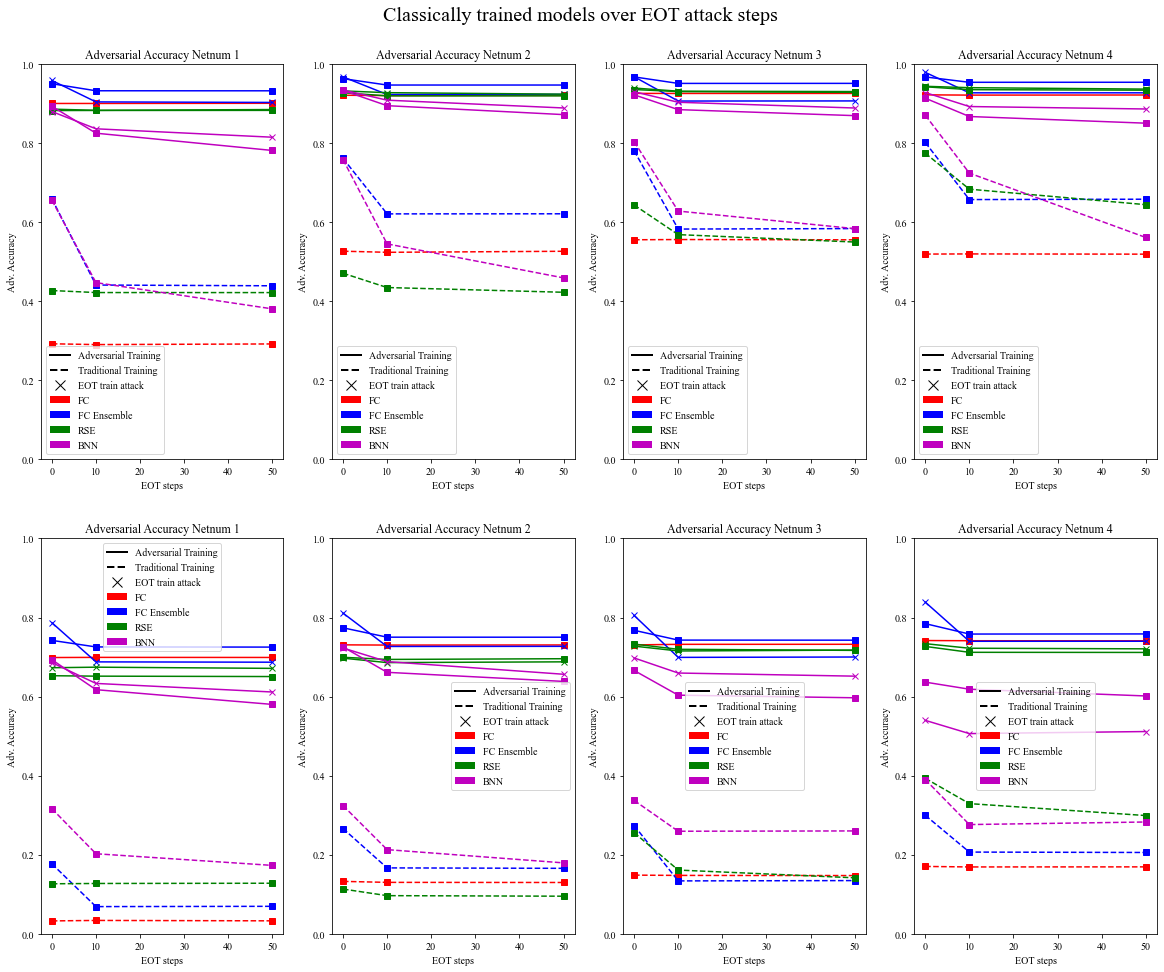

In [14]:
query_dict = {'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'n_epochs': n_epochs}
queried_data = query(complete_data, query_dict)

fig, ax = plt.subplots(2, 4, squeeze=False, figsize=(20, 16))

for h, training in enumerate(training_modes):
    for i, data_set in enumerate(data_set_names):
        for j, net_num in enumerate(architectures):
            for k, net_type in enumerate(net_types):
                for l, eot in enumerate(eot_train):
                    if (training == 'non_adv' or net_type == 'fc') and eot:
                        continue
                    query_to_plot = query(queried_data, {'training': training, 'data_set': data_set, 'net_type': net_type, 'net_num': net_num, 'eot_train': eot})
                    ax[i, j].plot(query_to_plot[:, -3], query_to_plot[:, -1], f'{colors[k]}{line_style[h]}{symbols[l]}')#, label=f'{training}')
            # ax[i, j].legend(bbox_to_anchor=(1.05, 0.5))
            ax[i, j].legend(handles=legend_lines)
            ax[i, j].set_ylim([0, 1])
            ax[i, j].set_title(f'Adversarial Accuracy Netnum {net_num}')
            ax[i, j].set_ylabel('Adv. Accuracy')
            ax[i, j].set_xlabel('EOT steps')
fig.suptitle('Classically trained models over EOT attack steps', fontsize=20, y=0.93)
plt.show()

We can see that in the case of no adversarial training, the inherent defence coming from the randomized models can not be countered easily by just a simple EOT attack. However, it is very evident that this kind of defense is weak when compared to adversarial training.

## Further Analysis

### How do the adversarial and the benign accuracies correlate in each model?

In [15]:
# Attack and training params
eps_test = 0.08
pgd_steps_test = 50
eot_train = False
eot_test = False

# Plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['x', 'o', 'v', 's']
trainings = ['non_adv', 'adv']
data_sets = ['mnist', 'fashion_mnist']

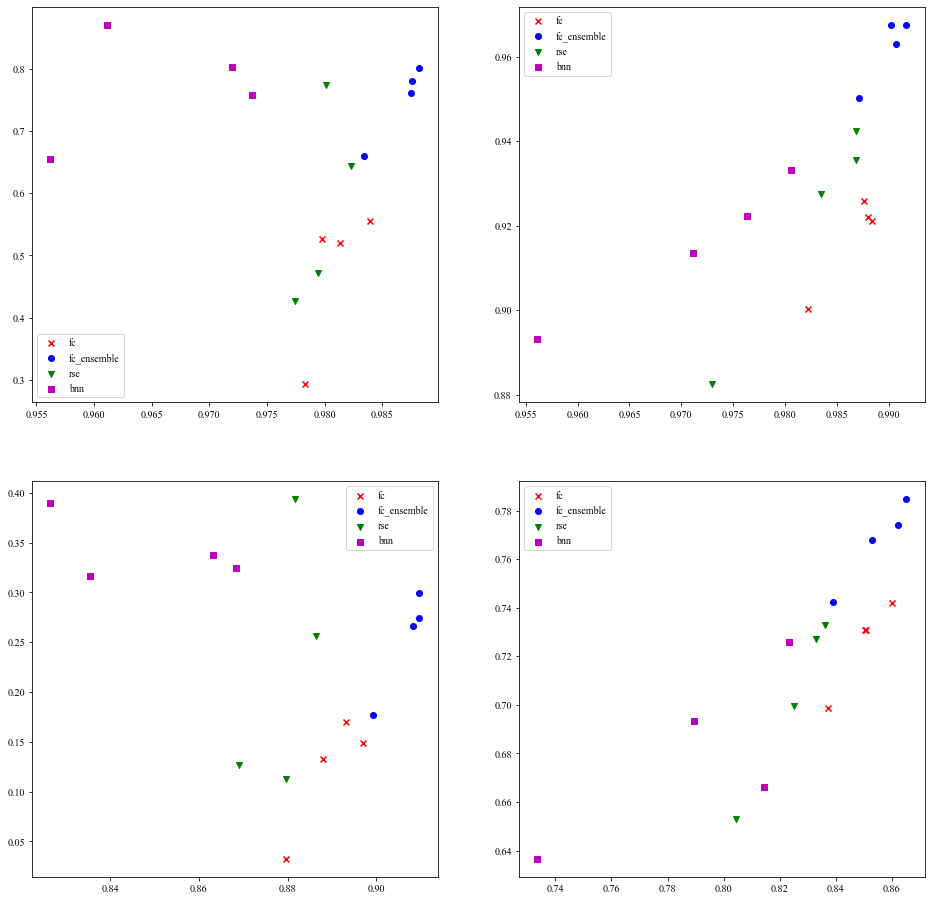

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))

for i, data_set in enumerate(data_sets):
    for j, training in enumerate(trainings):
        for k, net_type in enumerate(net_types):
            queried_data = query(complete_data, {'data_set': data_set, 'net_type': net_type, 'training': training, 'eot_train': eot_train, 'eot_test': eot_test,
                                                 'pgd_steps_test': pgd_steps_test, 'eps_test': eps_test, 'n_epochs': 50})
            ax[i, j].scatter(queried_data[:, -2], queried_data[:, -1], c=colors[k], marker=symbols[k], label=net_type)
            ax[i, j].legend()
plt.show()

Interestingly enough, the randomized models seem to display almost no correlation when not trained adversarially, showing much higher adversarial accuracy than what should be expected when compared to other models. It is also interesting to observe how adversarial training align the two accuracies, leading to the highlighting of how the lack of performance on the training task of randomized models transfers to a loss of adversarial performance when the training task is the classification of adversarial samples.

### What is the influence of the inner standard deviation on the performance of the RSEs?

In [17]:
# import torchvision
# from attacks import PGD
# import torch
# from models import FullyConnectedRSETester

In [18]:
# if torch.cuda.is_available():
#     print('CUDA is available, training on GPU')
# DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load data
# test_loader_mnist = torch.utils.data.DataLoader(torchvision.datasets.MNIST('./dataset/', train=False,
#                                                                             transform=torchvision.transforms.ToTensor(),
#                                                                             download=True),
#                                                  batch_size=1000, shuffle=True)
# test_loader_fashion_mnist = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./dataset/', train=False,
#                                                                                            transform=torchvision.transforms.ToTensor(),
#                                                                                            download=True),
#                                                          batch_size=1000, shuffle=True)

In [19]:
# stds = [10, 5, 1, 0.1]
# data_sets = {
#     'mnist': test_loader_mnist,
#     'fashion_mnist': test_loader_fashion_mnist
# }
# epochs = [1, 5, 10, 20, 50]

# base_prompt = 'pre_trained_models/misc_experiments/rse_exploration/'

In [20]:
# not adversarially trained models
# non_adv_data = []
# attack = PGD(n_iterations=10, epsilon=0.08, step_size=0.05, clamp=True, EOT=False, n=10)

# for std_inner in stds:
#     for data_set in data_sets:
#         folder_prompt = f'non_adv_rse_{std_inner}_{data_set}'
#         line = [std_inner, data_set]
#         tester = FullyConnectedRSETester(test_loader=data_sets[data_set], device=DEVICE, verbose=False)
#         for epoch in epochs:
#             model = torch.load(f'{base_prompt}{folder_prompt}/{folder_prompt}_epoch{epoch}.pt').to(DEVICE)
#             accuracy = tester.test(model)
#             adv_accuracy = tester.adversarial_test(model, attack)
#             print(f'STD: {std_inner}  Data Set: {data_set}  Epoch: {epoch}  Accuracy: {accuracy}  Adv Accuracy: {adv_accuracy}', end='\r')
#             line.append(accuracy)
#             line.append(adv_accuracy)
#         non_adv_data.append(line)

In [21]:
# adversarially trained models
# adv_data = []
# attack = PGD(n_iterations=10, epsilon=0.08, step_size=0.05, clamp=True, EOT=False, n=10)

# for std_inner in stds:
#     for data_set in data_sets:
#         folder_prompt = f'adv_rse_{std_inner}_{data_set}'
#         line = [std_inner, data_set]
#         tester = FullyConnectedRSETester(test_loader=data_sets[data_set], device=DEVICE, verbose=False)
#         for epoch in epochs:
#             model = torch.load(f'{base_prompt}{folder_prompt}/{folder_prompt}_epoch{epoch}.pt').to(DEVICE)
#             accuracy = tester.test(model)
#             adv_accuracy = tester.adversarial_test(model, attack)
#             print(f'STD: {std_inner}  Data Set: {data_set}  Epoch: {epoch}  Accuracy: {accuracy}  Adv Accuracy: {adv_accuracy}', end='\r')
#             line.append(accuracy)
#             line.append(adv_accuracy)
#         adv_data.append(line)

In [22]:
import pickle

with open('pre_trained_models/misc_experiments/rse_exploration/non_adv_accs.pkl', 'rb') as f:
    non_adv_data = pickle.load(f)
    
with open('pre_trained_models/misc_experiments/rse_exploration/adv_accs.pkl', 'rb') as f:
    adv_data = pickle.load(f)

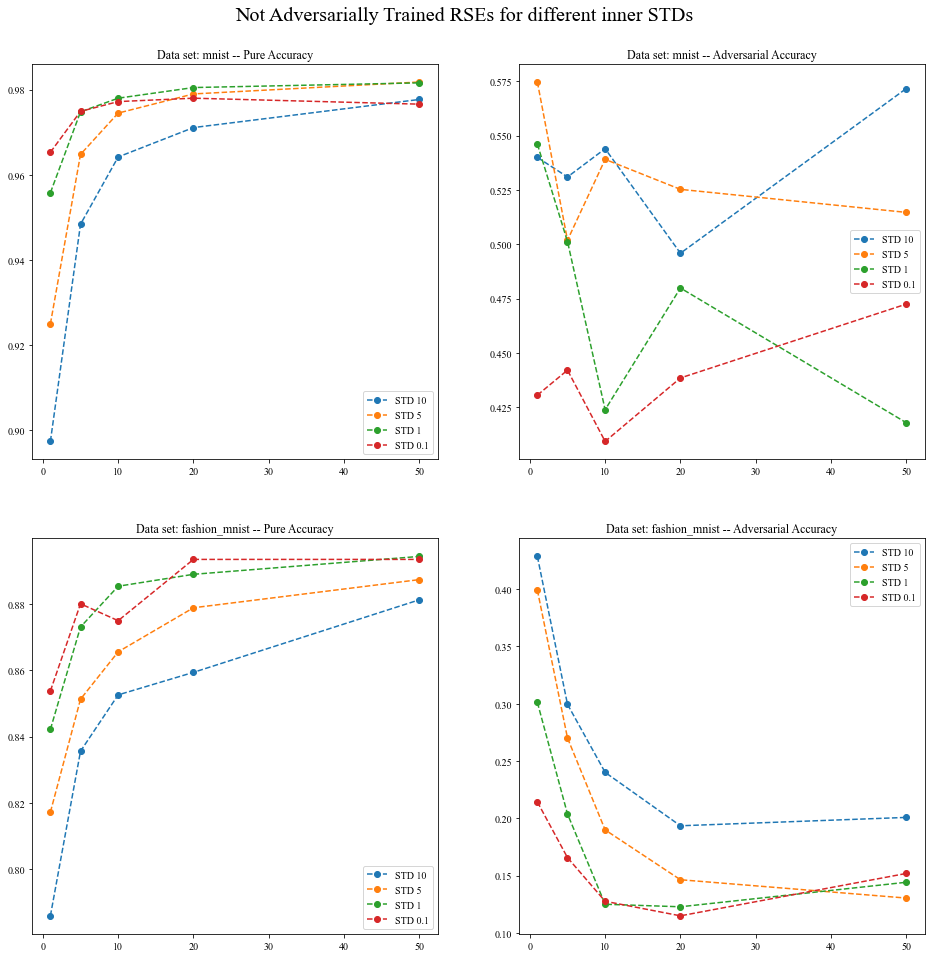

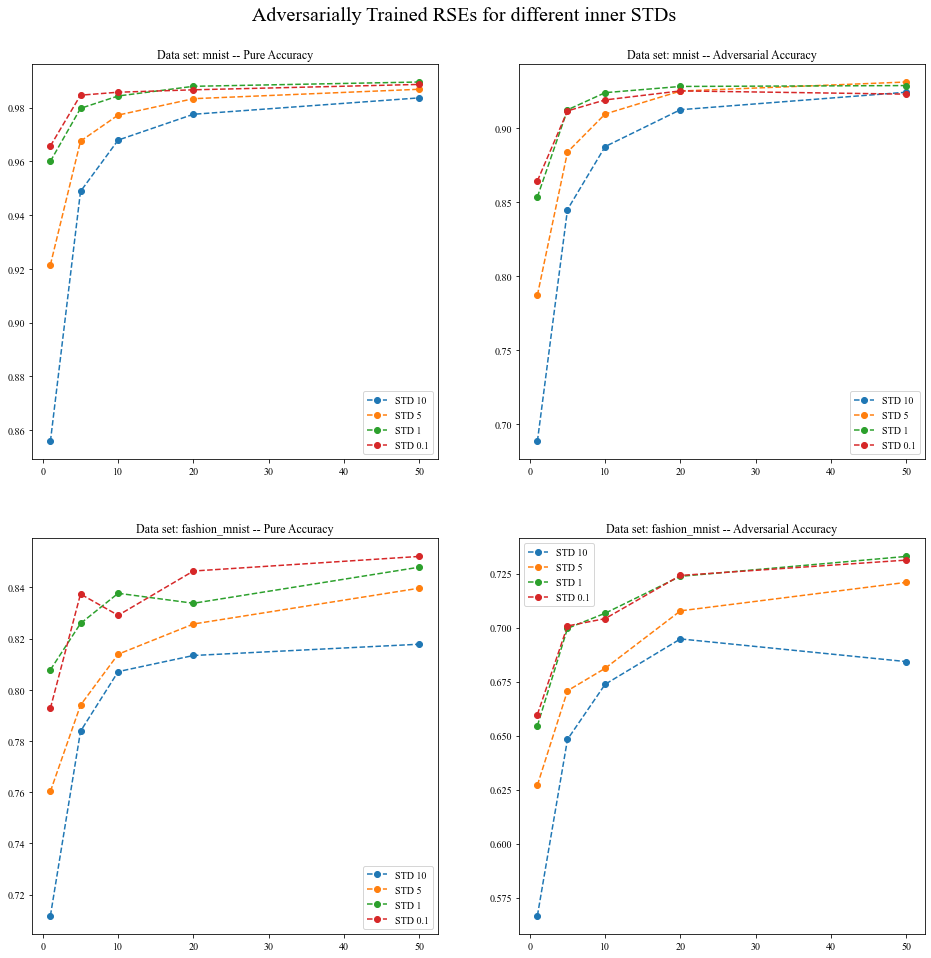

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(16, 16))
for line in non_adv_data:
    plot_row = 0 if line[1] == 'mnist' else 1
    accuracy = [line[idx*2] for idx in range(1, 6)]  
    adv_accuracy = [line[idx*2 + 1] for idx in range(1, 6)]
    # print(f'Data_set: {line[1]}  Accuracy: {np.around(accuracy[-1]*100, 3)}  Adv Accuracy: {np.around(adv_accuracy[-1]*100, 3)}  STD: {line[0]}')
    ax[plot_row, 0].plot(epochs, accuracy, '--o', label=f'STD {line[0]}')
    ax[plot_row, 1].plot(epochs, adv_accuracy, '--o', label=f'STD {line[0]}')
    ax[plot_row, 0].legend()
    ax[plot_row, 1].legend()
    ax[plot_row, 0].set_title(f'Data set: {line[1]} -- Pure Accuracy')
    ax[plot_row, 1].set_title(f'Data set: {line[1]} -- Adversarial Accuracy')
plt.suptitle('Not Adversarially Trained RSEs for different inner STDs', fontsize=20, y=0.93)
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(16, 16))
for line in adv_data:
    plot_row = 0 if line[1] == 'mnist' else 1
    accuracy = [line[idx*2] for idx in range(1, 6)]  
    adv_accuracy = [line[idx*2 + 1] for idx in range(1, 6)]
    # print(f'Data_set: {line[1]}  Accuracy: {np.around(accuracy[-1]*100, 3)}  Adv Accuracy: {np.around(adv_accuracy[-1]*100, 3)}  STD: {line[0]}')
    ax[plot_row, 0].plot(epochs, accuracy, '--o', label=f'STD {line[0]}')
    ax[plot_row, 1].plot(epochs, adv_accuracy, '--o', label=f'STD {line[0]}')
    ax[plot_row, 0].legend()
    ax[plot_row, 1].legend()
    ax[plot_row, 0].set_title(f'Data set: {line[1]} -- Pure Accuracy')
    ax[plot_row, 1].set_title(f'Data set: {line[1]} -- Adversarial Accuracy')
plt.suptitle('Adversarially Trained RSEs for different inner STDs', fontsize=20, y=0.93)
plt.show()

As expected, when using solely the randomness as th defense mechanism, the RSE with higher inner standard deviation (i.e. in some sense higher randomness) performs better under attack, but leaves more pure accuracy on the table. Whereas, when we switch to adversarial training we reinforce our observations made earlier; deterministic models seem to respond better to adversarial training, and as such the RSE models with lower inner STD exhibit better performance.

### What is the effect of randomness in the case of BNNs?

In [24]:
queried_data = query(complete_data, {'data_set': 'fashion_mnist', 'net_type': 'bnn', 'pgd_steps_test': 50, 'eps_test': 0.08, 'eot_test': False, 'eot_train': False})
training_styles = ['non_adv', 'adv']
net_nums = [1, 2, 3, 4]
line_style = ['--', '-']
colors = ['r', 'b', 'g', 'm']

In [25]:
# define the legend
legend_lines = [
    Line2D([0], [0], color='black', lw=2, label='Adversarial Training'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Traditional Training'),
    Patch(facecolor='r', label='Net 1'),
    Patch(facecolor='b', label='Net 2'),
    Patch(facecolor='g', label='Net 3'),
    Patch(facecolor='m', label='Net 4')
]

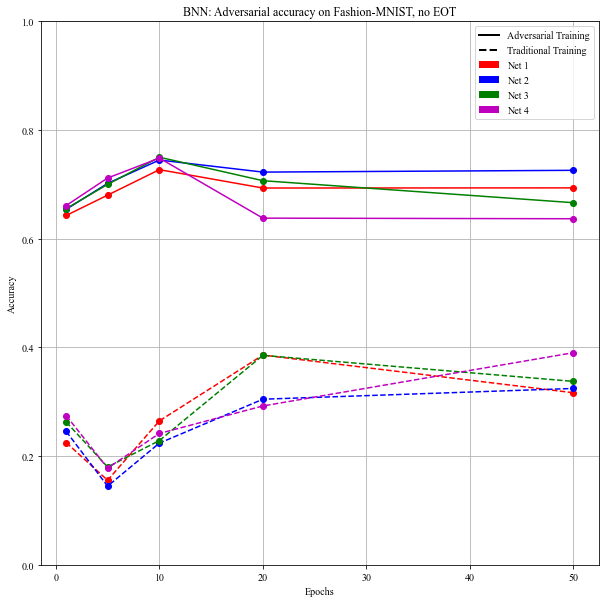

In [26]:
plt.figure(figsize=(10, 10))
for i, training in enumerate(training_styles):
    for j, net_num in enumerate(net_nums):
        query_to_plot = query(queried_data, {'training': training, 'net_num': net_num})
        plt.plot(query_to_plot[:, 3], query_to_plot[:, -1], f'{colors[j]}{line_style[i]}o')
plt.ylim([0, 1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BNN: Adversarial accuracy on Fashion-MNIST, no EOT')
plt.legend(handles=legend_lines)
plt.grid(True)
plt.show()

### Let us summarize all performances

At epoch 50 (assumed convergence), we collect each model's performance on both datasets under 1) no attack, 2) weak attack, and 3) strong attack. This should provide us with an immediate overview of the different model classes' performances and also highlight the division between deterministic and randomized models.

Here we only have the data extracted, the table can be found in the accompanying manuscript.

In [27]:
attacks = {'weak_attack': {'eps_test': 0.05, 'pgd_steps_test': 10, 'eot_test': False}, 'strong_attack': {'eps_test': 0.08, 'pgd_steps_test': 50, 'eot_test': False}}
models = ['fc', 'fc_ensemble', 'rse', 'bnn']
training = ['non_adv', 'adv']
data_set = ['mnist', 'fashion_mnist']
n_epochs = 50
eot_train = False

for model in models:
    print(f'Model: {model}')
    for training_type in training:
        print(f'Training: {training_type}')
        for data_set in data_sets:
            print(f'Data Set: {data_set}')
            current_data_sheet = {1: {}, 2: {}, 3: {}, 4: {}}
            for attack_name in attacks:
                attack = attacks[attack_name]
                eot_test = True if model == 'fc_ensemble' else False  # the collective attack is a white box attack in the case of ensembles
                current_query = query(complete_data, {'net_type': model, 'data_set': data_set, 'n_epochs': n_epochs, 'training': training_type, 'eot_train': eot_train, 
                                                      'eps_test': attack['eps_test'], 'pgd_steps_test': attack['pgd_steps_test'], 'eot_test': eot_test})
                for exp in current_query:
                    current_data_sheet[exp[1]][attack_name] = np.around(exp[-1]*100, 3)
                    current_data_sheet[exp[1]]['test_acc'] = np.around(exp[-2]*100, 3)
            for net_num in current_data_sheet:
                test_acc = current_data_sheet[net_num]['test_acc']
                weak_acc = current_data_sheet[net_num]['weak_attack']
                strong_acc = current_data_sheet[net_num]['strong_attack']
                print(f'{net_num}.:  Pure Accuracy: {test_acc}  Weak Attack Acc.: {weak_acc}  Strong Attack Acc.: {strong_acc}')
        print('\n')
    print('\n')

Model: fc
Training: non_adv
Data Set: mnist
1.:  Pure Accuracy: 97.83  Weak Attack Acc.: 65.71  Strong Attack Acc.: 29.24
2.:  Pure Accuracy: 97.98  Weak Attack Acc.: 81.01  Strong Attack Acc.: 52.66
3.:  Pure Accuracy: 98.39  Weak Attack Acc.: 84.35  Strong Attack Acc.: 55.55
4.:  Pure Accuracy: 98.13  Weak Attack Acc.: 83.37  Strong Attack Acc.: 51.93
Data Set: fashion_mnist
1.:  Pure Accuracy: 87.97  Weak Attack Acc.: 14.55  Strong Attack Acc.: 3.26
2.:  Pure Accuracy: 88.79  Weak Attack Acc.: 28.17  Strong Attack Acc.: 13.26
3.:  Pure Accuracy: 89.7  Weak Attack Acc.: 29.84  Strong Attack Acc.: 14.84
4.:  Pure Accuracy: 89.31  Weak Attack Acc.: 29.12  Strong Attack Acc.: 17.04


Training: adv
Data Set: mnist
1.:  Pure Accuracy: 98.22  Weak Attack Acc.: 94.66  Strong Attack Acc.: 90.03
2.:  Pure Accuracy: 98.84  Weak Attack Acc.: 96.16  Strong Attack Acc.: 92.11
3.:  Pure Accuracy: 98.76  Weak Attack Acc.: 96.07  Strong Attack Acc.: 92.58
4.:  Pure Accuracy: 98.8  Weak Attack Acc.: 

## Conclusion

We could confirm that randomization leads to a certain weak defense, however, when combined with adversarial training, this poses no additional defense. Rather, due to the fact that randomized models tend to perform worse on their training task than their deterministic counterparts, deterministic models prevail when adversarial training is used as a defense mechanism.

## Appendix

### Plots used in the manuscript

### Figure 1

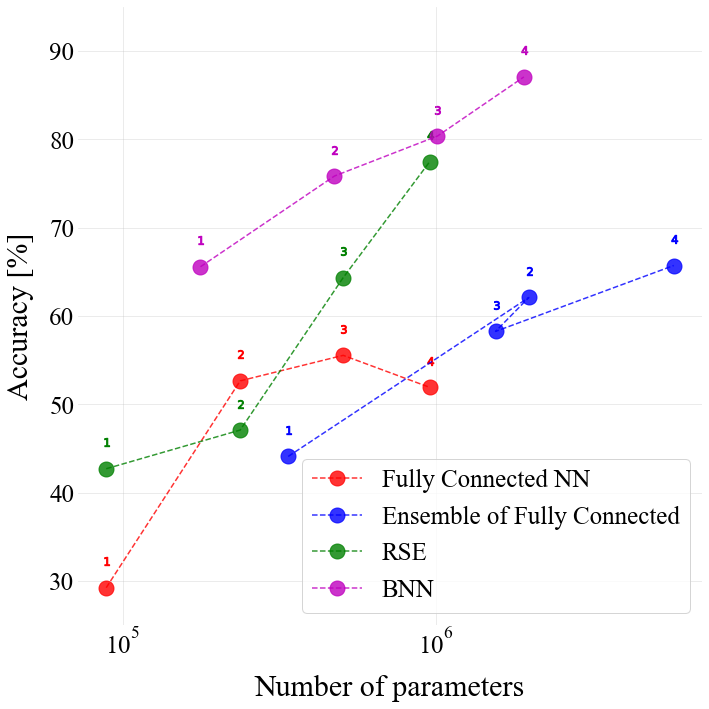

In [39]:
# Figure 1
# Attack params
pgd_steps_test = 50
eps_test = 0.08
n_epochs = 50
eot_train = False

# plot params
net_types = {'fc': 'Fully Connected NN', 'fc_ensemble': 'Ensemble of Fully Connected', 'rse': 'RSE', 'bnn': 'BNN'}
colors = ['r', 'b', 'g', 'm']
symbols = ['x', 'o', 'v', 's']
eot_steps = 0
eot_test_ensemble = True
data_set = 'mnist'

# fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(20, 6))
query_dict = {'training': 'non_adv', 'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'n_epochs': n_epochs, 'eot_train': False, 'data_set': data_set}
queried_data = query(complete_data, query_dict)

plt.figure(figsize=(10, 10))

for j, net_type in enumerate(net_types):
    x_to_plot = []
    y_to_plot = []
    for l, net_num in enumerate(architectures):
        if net_type == 'fc_ensemble':
            num_params = calculate_number_of_parameters(784, collective_architectures[l], net_type)
            query_to_plot = query(queried_data, {'net_num': net_num, 'net_type': net_type, 'eot_test': eot_test_ensemble})
        else:
            num_params = calculate_number_of_parameters(784, architecture_layouts[net_num], net_type)
            query_to_plot = query(queried_data, {'net_num': net_num, 'net_type': net_type, 'eot_steps_test': eot_steps})
        x_to_plot.append(num_params)
        y_to_plot.append(query_to_plot[0, -1]*100)
        plt.scatter(num_params, query_to_plot[0, -1]*100+3, marker=f'${net_num}$', c=colors[j], s=70)
    plt.plot(x_to_plot, y_to_plot, f'{colors[j]}--o', label=f'{net_types[net_type]}', markersize=15, alpha=0.8)
plt.legend(fontsize=25, loc='lower right')
plt.ylim([25, 95])
plt.xscale('log')
plt.xlabel('Number of parameters', fontsize=30, labelpad=15)
plt.ylabel('Accuracy [%]', fontsize=30, labelpad=15)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.box(False)
plt.tight_layout()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('plots/adv_acc_mnist_no_adv_train_no_eot_params.pdf')
plt.show()

### Figure 2

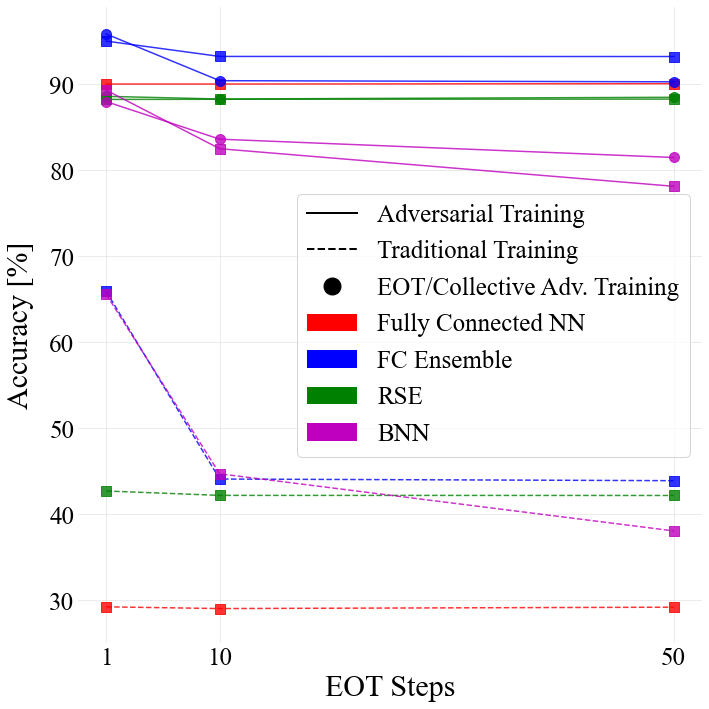

In [38]:
# Attack params
pgd_steps_test = 50
eps_test = 0.08
n_epochs = 50

# plot params
net_types = ['fc', 'fc_ensemble', 'rse', 'bnn']
colors = ['r', 'b', 'g', 'm']
symbols = ['o', 's']
eot_steps_test = [0, 10, 50]
eot_train = [True, False]
training_modes = ['non_adv', 'adv']
line_style = ['--', '-']
net_num = 1
data_set = 'mnist'

# define the legend
legend_lines = [
    Line2D([0], [0], color='black', lw=2, label='Adversarial Training'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Traditional Training'),
    Line2D([0], [0], color='black', linestyle='', markerfacecolor='black', marker='o', markersize=17, label='EOT/Collective Adv. Training'),
    Patch(facecolor='r', label='Fully Connected NN'),
    Patch(facecolor='b', label='FC Ensemble'),
    Patch(facecolor='g', label='RSE'),
    Patch(facecolor='m', label='BNN')
]

query_dict = {'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'n_epochs': n_epochs}
queried_data = query(complete_data, query_dict)

plt.figure(figsize=(10, 10))

for h, training in enumerate(training_modes):
    for k, net_type in enumerate(net_types):
        for l, eot in enumerate(eot_train):
            if (training == 'non_adv' or net_type == 'fc') and eot:
                continue
            query_to_plot = query(queried_data, {'training': training, 'data_set': data_set, 'net_type': net_type, 'net_num': net_num, 'eot_train': eot})
            plt.plot(query_to_plot[:, -3], query_to_plot[:, -1]*100, f'{colors[k]}{line_style[h]}{symbols[l]}', markersize=10, alpha=0.8)
plt.legend(handles=legend_lines, fontsize=25, loc='center right')
plt.ylim([25, 99])
plt.ylabel('Accuracy [%]', fontsize=30, labelpad=15)
plt.xlabel('EOT Steps', fontsize=30)
plt.yticks(fontsize=25)
plt.xticks([0, 10, 50], [1, 10, 50], fontsize=25)
plt.grid(True, alpha=0.3)
plt.box(False)
plt.tight_layout()
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.savefig('plots/eot_adv_acc_combined_net1.pdf')
plt.show()

### Figure 3

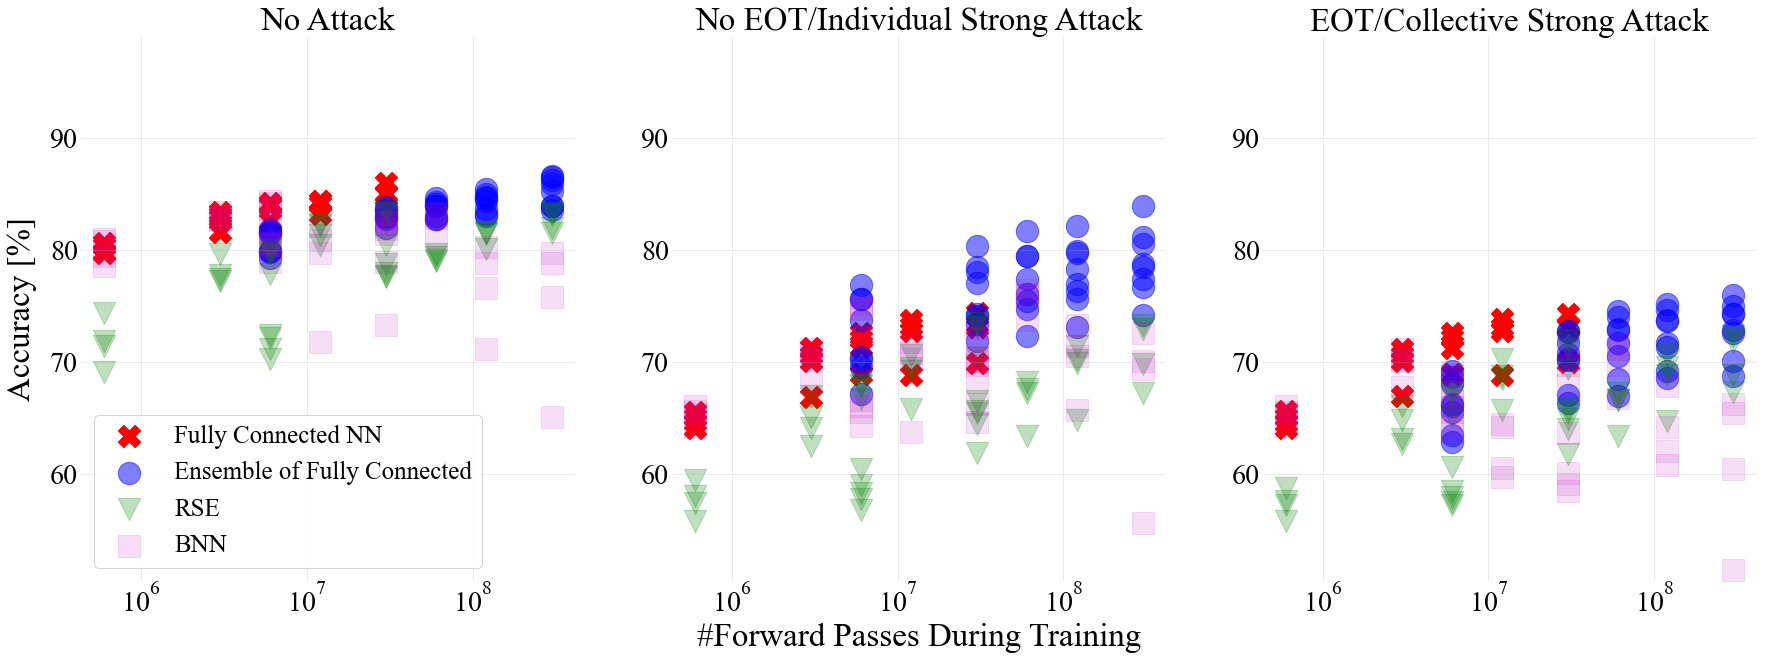

In [36]:
# Attack params
pgd_steps_test = 10
eps_test = 0.08
n_epochs = 50
eot_train = False

# plot params
net_types = {'fc': 'Fully Connected NN', 'fc_ensemble': 'Ensemble of Fully Connected', 'rse': 'RSE', 'bnn': 'BNN'}
colors = ['r', 'b', 'g', 'm']
symbols = ['X', 'o', 'v', 's']
eot_steps_test = [0, 0, 50]
epochs = [1, 5, 10, 20, 50]
eot_train = [True, False]
data_set = 'fashion_mnist'

query_dict = {'eps_test': eps_test, 'pgd_steps_test': pgd_steps_test, 'training': 'adv'}  # change 'training': 'non_adv' to compare the performance of traditionally trained models
queried_data = query(complete_data, query_dict)

fig, ax = plt.subplots(1, 3, squeeze=False, figsize=(30, 10))# , sharey=True, sharex=True)

for j, eot_steps in enumerate(eot_steps_test):
    for k, net_type in enumerate(net_types):
        query_to_plot = query(queried_data, {'net_type': net_type, 'eot_steps_test': eot_steps, 'data_set': data_set})
        x_to_plot = []
        y_to_plot = []
        for line in query_to_plot:
            if j == 0:
                y_to_plot.append(line[-2]*100)
            else:
                y_to_plot.append(line[-1]*100)
            # calculate how many forward passes were needed for training
            iterations = calculate_number_of_passes_for_training(line[3], 60000)
            if line[4] == 'adv':
                special_attack = line[7]
                special_attack_factor = 10
                if net_type == 'fc_ensemble':
                    special_attack = ~special_attack
                    pecial_attack_factor = len(collective_architectures[line[1]-1])
                pgd_steps = line[6]
                iterations *= calculate_number_of_passes_for_pgd(pgd_steps=pgd_steps, special_attack=special_attack, special_attack_factor=special_attack_factor)
            else:
                iterations *= len(collective_architectures[line[1]-1]) if net_type == 'fc_ensemble' else 1
            x_to_plot.append(iterations)
        ax[0, j].scatter(x_to_plot, y_to_plot, s=500, c=colors[k], marker=symbols[k], alpha=0.5**k, label=net_types[net_type])
        ax[0, j].set_ylim([50.5, 99])  # adjust here in case some parts of the plot are not visible
        ax[0, j].set_xscale('log')
        ax[0, j].tick_params(axis='x', labelsize=28)
        ax[0, j].tick_params(axis='y', labelsize=28)
        ax[0, j].grid(True, alpha=0.3)
        ax[0, j].set_frame_on(False)
        ax[0, j].tick_params(axis=u'both', which=u'both',length=0)
ax[0, 0].legend(fontsize=25)
ax[0, 0].set_title(f'No Attack', fontsize=33)
ax[0, 1].set_title(f'No EOT/Individual Strong Attack', fontsize=33)
ax[0, 2].set_title(f'EOT/Collective Strong Attack', fontsize=33, y=1)
#fig.tight_layout()
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('Accuracy [%]', fontsize=33, labelpad=25)
plt.xlabel('#Forward Passes During Training', fontsize=33, labelpad=25)
#plt.tight_layout()
plt.savefig('plots/accs_adv_train_number_passes_training.pdf', bbox_inches='tight')
plt.show()

### Figure 4

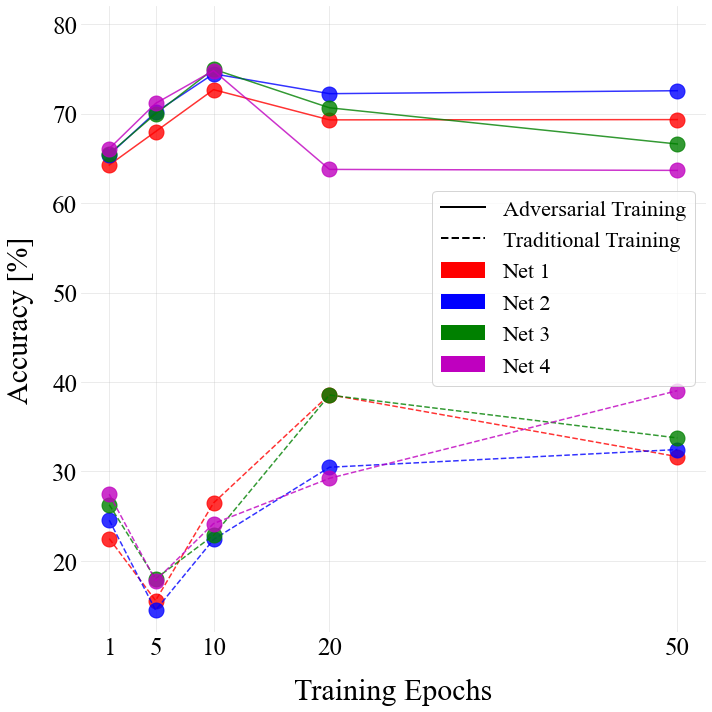

In [63]:
queried_data = query(complete_data, {'data_set': 'fashion_mnist', 'net_type': 'bnn', 'pgd_steps_test': 50, 'eps_test': 0.08, 'eot_test': False, 'eot_train': False})
training_styles = ['non_adv', 'adv']
net_nums = [1, 2, 3, 4]
line_style = ['--', '-']
colors = ['r', 'b', 'g', 'm']

# define the legend
legend_lines = [
    Line2D([0], [0], color='black', lw=2, label='Adversarial Training'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Traditional Training'),
    Patch(facecolor='r', label='Net 1'),
    Patch(facecolor='b', label='Net 2'),
    Patch(facecolor='g', label='Net 3'),
    Patch(facecolor='m', label='Net 4')
]

plt.figure(figsize=(10, 10))
for i, training in enumerate(training_styles):
    for j, net_num in enumerate(net_nums):
        query_to_plot = query(queried_data, {'training': training, 'net_num': net_num})
        plt.plot(query_to_plot[:, 3], query_to_plot[:, -1]*100, f'{colors[j]}{line_style[i]}o', markersize=15, alpha=0.8)
plt.ylim([12, 82])
plt.xlabel('Training Epochs', fontsize=30, labelpad=18)
plt.ylabel('Accuracy [%]', fontsize=30, labelpad=18)
plt.yticks(fontsize=25)
plt.xticks([1, 5, 10, 20, 50], fontsize=25)
plt.legend(handles=legend_lines, fontsize=22, loc='center right', bbox_to_anchor=(1, 0.55))
plt.grid(True, alpha=0.3)
plt.box(False)
plt.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.savefig('plots/bnn_adv_train_trad_train_fashion_mnist.pdf')
plt.show()